# Reinforcement Learning Project

## Setup

To be able to run this notebook properly please make sure to install the pettingzoo package and dependencies. This can be done by running the following command

`pip install pettingzoo[mpe]`

### Imports

In [1]:
from pettingzoo.mpe import simple_world_comm_v2
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pprint import pprint
from matplotlib import pyplot as plt
import time
import datetime

### Environment Initialisation

In [2]:
MAX_CYCLES = 50
# Keep as a multiple of 10
NUM_OF_EPISODES = 500
MEANING_OF_LIFE = 42
ENVIRONMENT_NAME = "simple_world_comm"

env = simple_world_comm_v2.env(num_good=2, num_adversaries=4, num_obstacles=1,
                num_food=2, max_cycles=MAX_CYCLES, num_forests=2, continuous_actions=False)




env.reset(seed=MEANING_OF_LIFE)
print(f"Agents: {env.agents}")
print()
agent_mapping = {k: v for v, k in enumerate(env.agents)}
inv_agent_map = {v: k for k, v in agent_mapping.items()}
NUM_OF_AGENTS = len(env.agents)


Agents: ['leadadversary_0', 'adversary_0', 'adversary_1', 'adversary_2', 'agent_0', 'agent_1']



### Policy Function

In [3]:
def random_policy(actions):
    return random.randint(0, actions-1)

### Inspection Functions

A collection of inspection functions to help minimise clutter in the training loop below.

In [4]:
def matching_agent_only(agent, desired_agent, function, function_args):
#     To use this function, pass the agent and desired agent as the first two arguments,
#     then pass the function reference and the arguments for the function as a tuple for the final argument.
    if agent == desired_agent:
        function(*function_args)


def print_agent_rewards(agent, reward):
    print(f"{agent}:{reward}")
    
def print_agent_state(agent, observation):
    print(f"{agent}: {observation}")
    
def print_iter_info(agent,observation,reward,done,info):
    print(f"Current Agent: {agent}")
    print(f"Obs: {observation}")
    print(f"Rew: {reward}")      
    print(f"Done: {done}")
    print(f"Info: {info}")

def get_current_step(env):
    return env.env.env.steps

def np_array_no_e(array):
    np.set_printoptions(suppress=True)
    print(array)
    np.set_printoptions(suppress=False)

### Running the environment

The `env.render(mode='human')` call will pop open a new window that shows the environment at each time step.

On my machine at least this window can only be closed while the cell is running but then freezes and is unable to be closed afterwards. In these cases restarting the kernel closed the window and any others which may have been opened due to running the cell multiple times.

Eventually running the cell enough times without restarting the kernal will cause the render call to throw an exception and not run. In this case just restart the kernal and it will begin working again.

In [5]:
class agent_stub:
    def __init__(self):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return random_policy(env.action_space(agent).n)
    
    def save_action_state(self, action, state):
        pass
    
    def save_memory(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass

    def update_target_network_weights(self):
        pass

In [6]:
class good_agent_stub:
    def __init__(self):
        self.target_update_steps = 123456789123456789
    
    def policy(self, state):
        return 0
    
    def save_action_state(self, action, state):
        pass
    
    def save_memory(self, state, reward, done):
        pass
    
    def replay(self):
        pass

    def predict(self, state):
        pass
    
    def update_target_network_weights(self):
        pass

In [7]:
class agent:
    
    def __init__(self, agent_name, state_size, epsilon=1, epsilon_min = 0.1, 
                 epsilon_decay = 0.975, batch_size=8, learning_decay_rate = 0.95,
                target_update_steps = 10, action_space=5, experience_replay = True):
        
        self.state_size = state_size
        self.action_space = 5
        self.model = self.build_model()
        self.target_model = self.build_model()
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.agent_name = agent_name
        self.history = []
        self.action_taken = None
        self.previous_state = None
        self.batch_size = batch_size
        self.gamma = learning_decay_rate
        self.target_update_steps = target_update_steps
        self.update_target_network_weights()
        self.replay_enabled = experience_replay
    
    def build_model(self):
        model = keras.Sequential()
        model.add(layers.Dense(self.state_size, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(32, activation="relu"))
        model.add(layers.Dense(self.action_space, activation="relu"))
        model.compile(loss=keras.losses.Huber(), 
                      optimizer = keras.optimizers.Adam(learning_rate=0.00025))
 
        return model
    
    def exploration_decay(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)
            
    def save_model(self, agent_filename, target_filename):
        self.model.save(agent_filename+".h5")
        self.target_model.save(target_filename+".h5")
    
    def load_model(self, agent_filename, target_filename):
        self.model.load_weights(agent_filename)
        self.target_model.load_weights(target_filename)
        
    def policy(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space)
        action_vals = self.predict(state)
        return np.argmax(action_vals[0])
    
    def save_action_state(self, action, state):
        self.action_taken = action
        self.previous_state = state
        
    def save_history(self, state, reward, done):
        if self.previous_state is None and self.action_taken is None:
            self.previous_state = state
            self.action_taken = 0
        self.history.append((self.previous_state, self.action_taken, reward, state, done))
    
    def get_history(self):
        return self.history
    
    def replay(self):
        if self.replay_enabled:
            if len(self.history) < self.batch_size:
                return
            sample_batch = random.sample(self.history, self.batch_size)
            targets = []
            states = []

            for state, action, reward, next_state, done in sample_batch:
                target = reward
                if not done:
                    target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
                target_f = self.predict(state)
                target_f[0][action] = target
                targets.append(target_f[0])
                states.append(state)      
            
#             print(np.asarray(targets).shape)
#             print(np.asarray(states).shape)
            
            self.model.fit(np.asarray(states),np.asarray(targets), epochs=1, verbose=0, batch_size=self.batch_size)
        else:
#             print(self.history[-1])
            state, action, reward, next_state, done = self.history[-1]
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_predict(next_state)[0])
            target_f = self.predict(state)
            target_f[0][action] = target
            state = np.reshape(state, (1,self.state_size))
            self.model.fit(state,target_f, epochs=1, verbose=0,)
        
        self.exploration_decay()
    
    def get_learning_steps(self):
        return self.learning_steps
    
    def predict(self, state):
#         print(f"Before Reshape: {state}")
        state = np.reshape(state, (1,self.state_size))
#         print(f"After Reshape: {state}")
        return self.model.predict(state)

    def target_predict(self, state):
        state = np.reshape(state, (1,self.state_size))
        return self.target_model.predict(state)

    def update_target_network_weights(self):
        self.target_model.set_weights(self.model.get_weights())

In [8]:

env.reset(seed=MEANING_OF_LIFE)
reward_array = np.zeros((NUM_OF_EPISODES,len(env.agents)))

cumulative_reward = np.zeros(len(env.agents))
i = 0
agent_models = {}

ten_percent_episodes = int(NUM_OF_EPISODES/10)
save_models = True


# Creates the models. Models are shared between multiple adversaries and agents so for the first one of
# each type it creates the models while subsequent agents get the reference to the model passed as their
# 'model'
for key in agent_mapping:
    if key == "leadadversary_0":
        agent_models[key] = agent(key, env.observation_space(key)._shape[0], 
                                  action_space=env.action_space("leadadversary_0").n)
    elif "adversary" in key:
        if key == "adversary_0":    
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["adversary_0"]
    elif "agent" in key:
        if "agent_0" == key:
            agent_models[key] = agent(key, env.observation_space(key)._shape[0])
        else:
            agent_models[key] = agent_models["agent_0"]

cycle_scores = np.zeros((len(env.agents), NUM_OF_EPISODES,MAX_CYCLES+1))
step = -1
episode_times = []  


for episode in range(NUM_OF_EPISODES):
    print(f"Episode {episode+1} out of {NUM_OF_EPISODES}")
    env.reset(seed=MEANING_OF_LIFE)
    cumulative_reward.fill(0)
    if episode > 0:
        print(f"Time taken for previous episode: {time.time()-episode_start_time}")
    episode_start_time = time.time()
    
    for agent in env.agent_iter():
        step_time = time.time()    
        if step != get_current_step(env):
#             print(f"Step: {get_current_step(env)}/{MAX_CYCLES}")
            step = get_current_step(env)
#         print(agent)
        
        observation, reward, done, info = env.last()
        cumulative_reward[agent_mapping[agent]] += reward
        cycle_scores[agent_mapping[agent]][episode][step] = reward
        
        agent_models[agent].save_history(observation, reward, done)
        
        if agent in ["leadadversary_0", "adversary_2", "agent_1"]:
            agent_models[agent].replay()
            if (step % agent_models[agent].target_update_steps) == 0:
                agent_models[agent].update_target_network_weights()

            if (episode % ten_percent_episodes == 0) and save_models:
                agent_models[agent].save_model(
                    ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_model",
                ENVIRONMENT_NAME+"_"+agent+"_"+str(episode)+"_of_"+str(NUM_OF_EPISODES)+"_target_model")

            
    #     Renders the environment for each step in a seperate window.        
#         env.render(mode='human')
    
    
    #     Steps the environment forward.
        if done:
            env.step(None)
            reward_array[episode,agent_mapping[agent]] = cumulative_reward[agent_mapping[agent]]
        else:
            action_to_take = agent_models[agent].policy(observation)
            env.step(action_to_take)
            agent_models[agent].save_action_state(action_to_take, observation)
        
#         print(f"Step Time: {time.time()-step_time}")
   

    episode_time = time.time()-episode_start_time
    episode_times.append(episode_time)
    print(f"Episode Time: {episode_time}")


Episode 1 out of 500
Episode Time: 78.1655626296997
Episode 2 out of 500
Time taken for previous episode: 78.1655626296997
Episode Time: 81.60437321662903
Episode 3 out of 500
Time taken for previous episode: 81.60487222671509
Episode Time: 78.25723123550415
Episode 4 out of 500
Time taken for previous episode: 78.2577314376831
Episode Time: 80.72109985351562
Episode 5 out of 500
Time taken for previous episode: 80.72160410881042
Episode Time: 81.33448767662048
Episode 6 out of 500
Time taken for previous episode: 81.33498215675354
Episode Time: 80.77791953086853
Episode 7 out of 500
Time taken for previous episode: 80.77842020988464
Episode Time: 80.5392005443573
Episode 8 out of 500
Time taken for previous episode: 80.53970074653625
Episode Time: 80.86632752418518
Episode 9 out of 500
Time taken for previous episode: 80.86682724952698
Episode Time: 80.54941010475159
Episode 10 out of 500
Time taken for previous episode: 80.54941010475159
Episode Time: 80.52236127853394
Episode 11 out

Episode Time: 78.6237461566925
Episode 81 out of 500
Time taken for previous episode: 78.62424635887146
Episode Time: 78.92924046516418
Episode 82 out of 500
Time taken for previous episode: 78.92974066734314
Episode Time: 78.25450420379639
Episode 83 out of 500
Time taken for previous episode: 78.25500535964966
Episode Time: 78.15386581420898
Episode 84 out of 500
Time taken for previous episode: 78.15436553955078
Episode Time: 78.03329110145569
Episode 85 out of 500
Time taken for previous episode: 78.03379082679749
Episode Time: 78.65906977653503
Episode 86 out of 500
Time taken for previous episode: 78.65906977653503
Episode Time: 79.09502482414246
Episode 87 out of 500
Time taken for previous episode: 79.09552502632141
Episode Time: 78.58199167251587
Episode 88 out of 500
Time taken for previous episode: 78.58249378204346
Episode Time: 77.88469505310059
Episode 89 out of 500
Time taken for previous episode: 77.88519525527954
Episode Time: 78.53513503074646
Episode 90 out of 500
Ti

Episode Time: 78.1786277294159
Episode 159 out of 500
Time taken for previous episode: 78.1786277294159
Episode Time: 77.95299983024597
Episode 160 out of 500
Time taken for previous episode: 77.95350003242493
Episode Time: 78.8615870475769
Episode 161 out of 500
Time taken for previous episode: 78.86209297180176
Episode Time: 77.86066389083862
Episode 162 out of 500
Time taken for previous episode: 77.86066389083862
Episode Time: 78.18782091140747
Episode 163 out of 500
Time taken for previous episode: 78.18834686279297
Episode Time: 78.38256120681763
Episode 164 out of 500
Time taken for previous episode: 78.38306069374084
Episode Time: 78.4864706993103
Episode 165 out of 500
Time taken for previous episode: 78.48697328567505
Episode Time: 78.37155985832214
Episode 166 out of 500
Time taken for previous episode: 78.37205982208252
Episode Time: 78.92510104179382
Episode 167 out of 500
Time taken for previous episode: 78.9256010055542
Episode Time: 78.53097081184387
Episode 168 out of 

Episode Time: 79.5645501613617
Episode 237 out of 500
Time taken for previous episode: 79.56506371498108
Episode Time: 77.92094945907593
Episode 238 out of 500
Time taken for previous episode: 77.92145252227783
Episode Time: 78.54022860527039
Episode 239 out of 500
Time taken for previous episode: 78.54072880744934
Episode Time: 78.32604312896729
Episode 240 out of 500
Time taken for previous episode: 78.32604312896729
Episode Time: 78.91802668571472
Episode 241 out of 500
Time taken for previous episode: 78.9185266494751
Episode Time: 78.75064992904663
Episode 242 out of 500
Time taken for previous episode: 78.75115036964417
Episode Time: 78.4352159500122
Episode 243 out of 500
Time taken for previous episode: 78.43573594093323
Episode Time: 78.13838648796082
Episode 244 out of 500
Time taken for previous episode: 78.13838648796082
Episode Time: 78.25524663925171
Episode 245 out of 500
Time taken for previous episode: 78.25574803352356
Episode Time: 78.81549263000488
Episode 246 out o

Episode Time: 78.1340639591217
Episode 315 out of 500
Time taken for previous episode: 78.1340639591217
Episode Time: 78.82479572296143
Episode 316 out of 500
Time taken for previous episode: 78.82529592514038
Episode Time: 78.80825972557068
Episode 317 out of 500
Time taken for previous episode: 78.80875968933105
Episode Time: 78.1480815410614
Episode 318 out of 500
Time taken for previous episode: 78.1480815410614
Episode Time: 78.6308822631836
Episode 319 out of 500
Time taken for previous episode: 78.63138151168823
Episode Time: 79.22972655296326
Episode 320 out of 500
Time taken for previous episode: 79.22972655296326
Episode Time: 79.03100347518921
Episode 321 out of 500
Time taken for previous episode: 79.03100347518921
Episode Time: 79.38185334205627
Episode 322 out of 500
Time taken for previous episode: 79.38185334205627
Episode Time: 78.5659875869751
Episode 323 out of 500
Time taken for previous episode: 78.5659875869751
Episode Time: 78.16481518745422
Episode 324 out of 50

Episode Time: 78.39669466018677
Episode 393 out of 500
Time taken for previous episode: 78.39719486236572
Episode Time: 78.75637626647949
Episode 394 out of 500
Time taken for previous episode: 78.75687599182129
Episode Time: 78.27144455909729
Episode 395 out of 500
Time taken for previous episode: 78.27194476127625
Episode Time: 78.49425482749939
Episode 396 out of 500
Time taken for previous episode: 78.49475741386414
Episode Time: 79.23307228088379
Episode 397 out of 500
Time taken for previous episode: 79.23307228088379
Episode Time: 78.86680698394775
Episode 398 out of 500
Time taken for previous episode: 78.86680698394775
Episode Time: 78.05659317970276
Episode 399 out of 500
Time taken for previous episode: 78.05709290504456
Episode Time: 78.36649894714355
Episode 400 out of 500
Time taken for previous episode: 78.367023229599
Episode Time: 78.13697504997253
Episode 401 out of 500
Time taken for previous episode: 78.13697504997253
Episode Time: 83.2998776435852
Episode 402 out o

Episode Time: 78.52202534675598
Episode 471 out of 500
Time taken for previous episode: 78.52252531051636
Episode Time: 78.41600012779236
Episode 472 out of 500
Time taken for previous episode: 78.41649985313416
Episode Time: 78.22133588790894
Episode 473 out of 500
Time taken for previous episode: 78.22133588790894
Episode Time: 78.50668597221375
Episode 474 out of 500
Time taken for previous episode: 78.50718569755554
Episode Time: 78.52610945701599
Episode 475 out of 500
Time taken for previous episode: 78.52663373947144
Episode Time: 78.76784443855286
Episode 476 out of 500
Time taken for previous episode: 78.76784443855286
Episode Time: 77.67772579193115
Episode 477 out of 500
Time taken for previous episode: 77.67822647094727
Episode Time: 78.48750066757202
Episode 478 out of 500
Time taken for previous episode: 78.4880006313324
Episode Time: 78.33398103713989
Episode 479 out of 500
Time taken for previous episode: 78.33398103713989
Episode Time: 78.31935214996338
Episode 480 out

In [9]:
# Closs the render window.
# env.close()
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Print Reward Array

In [10]:
np_array_no_e(reward_array)

x = 1

with open(f"{ENVIRONMENT_NAME}_DQN_{NUM_OF_EPISODES}ep.csv", "w+") as f:
    f.write("episode,adversary_0,agent_0\n")
    for j, i in enumerate(reward_array):
        f.write(f"{x}, {i[0]},{i[1]}, {i[2]},{i[3]},{i[4]},{i[5]}\n")
        x += 1

[[  -9.65162208   -8.02482011   -3.81389826   -5.14856855   -4.26167926
   -13.34395505]
 [  -4.99187833  -10.13183907  -10.94518413   -3.99795634   -2.89309914
    -6.87546491]
 [  -8.47882245   -4.77541068   -4.83170835   -4.35318642  -93.76698235
  -125.40590673]
 ...
 [  -6.12634219   -5.85395023   -3.91190038   -5.24326416   -3.02885456
    -2.71387523]
 [  -5.44064896   -4.70582447   -3.15209749   -4.01846371   -3.54257492
    -2.21366925]
 [   3.65290917    3.22225674    8.28098043    4.66851985   -3.12363414
   -83.45344322]]


In [11]:
# np_array_no_e(cycle_scores[0])
# print()
# print()
# print()
# np_array_no_e(cycle_scores[1])
# np_array_no_e(cycle_scores[1].sum(axis=1))

In [12]:
print(str(datetime.timedelta(seconds=np.mean(episode_times))))

0:01:18.764630


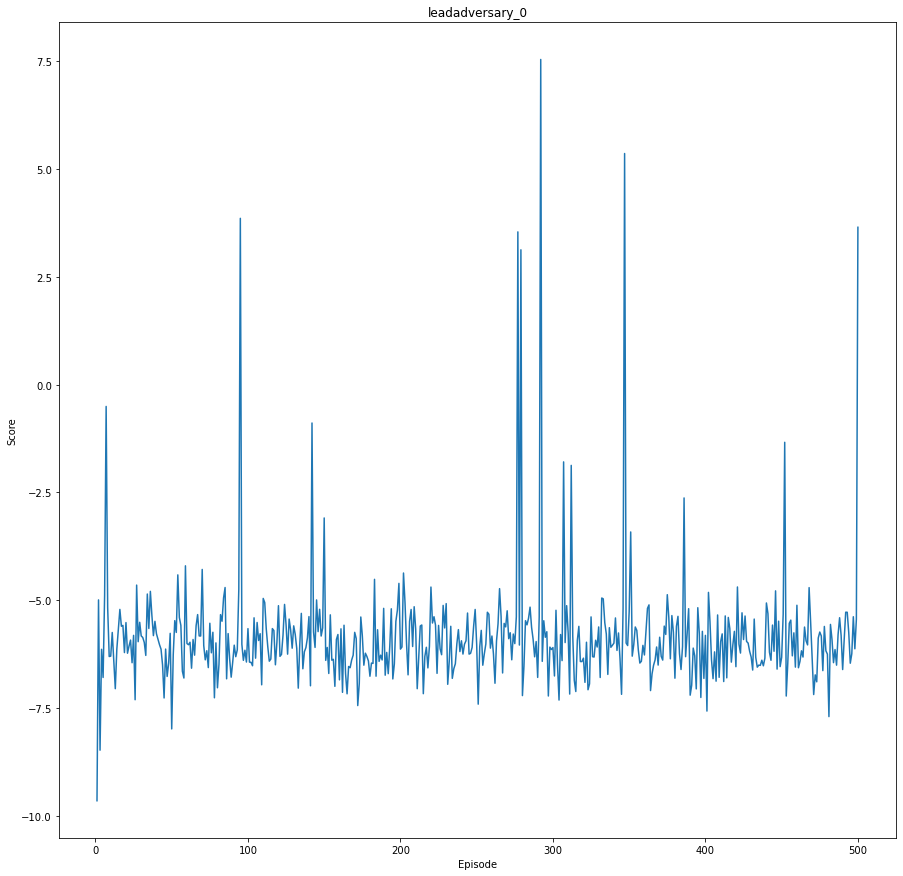

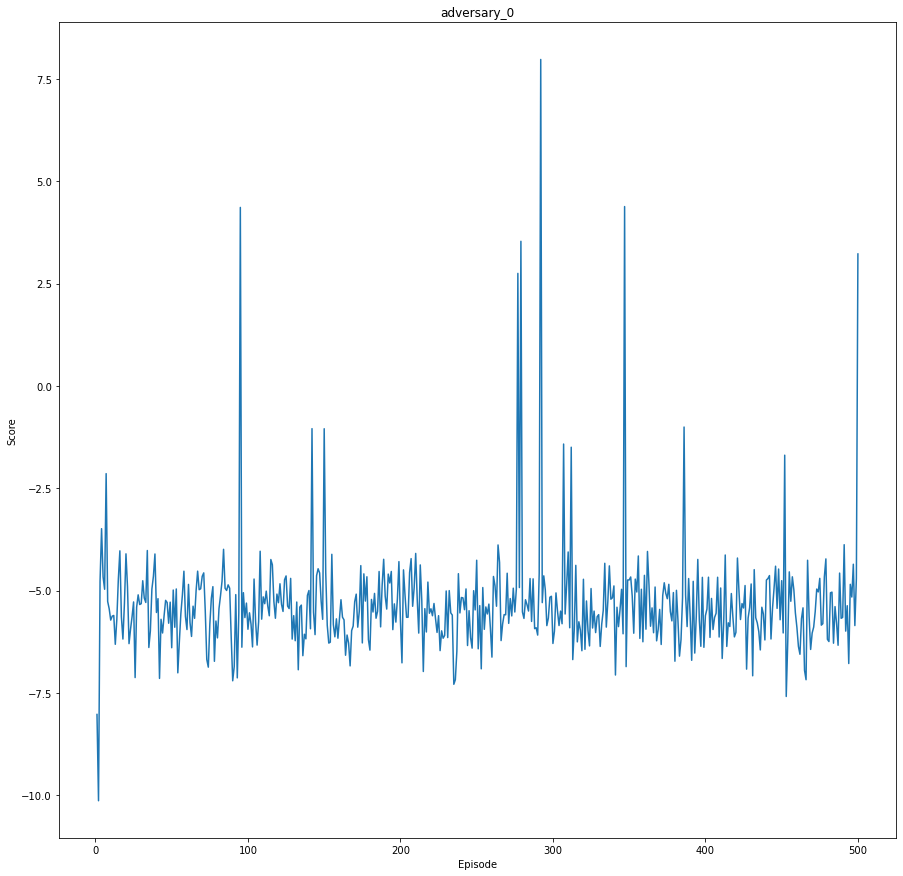

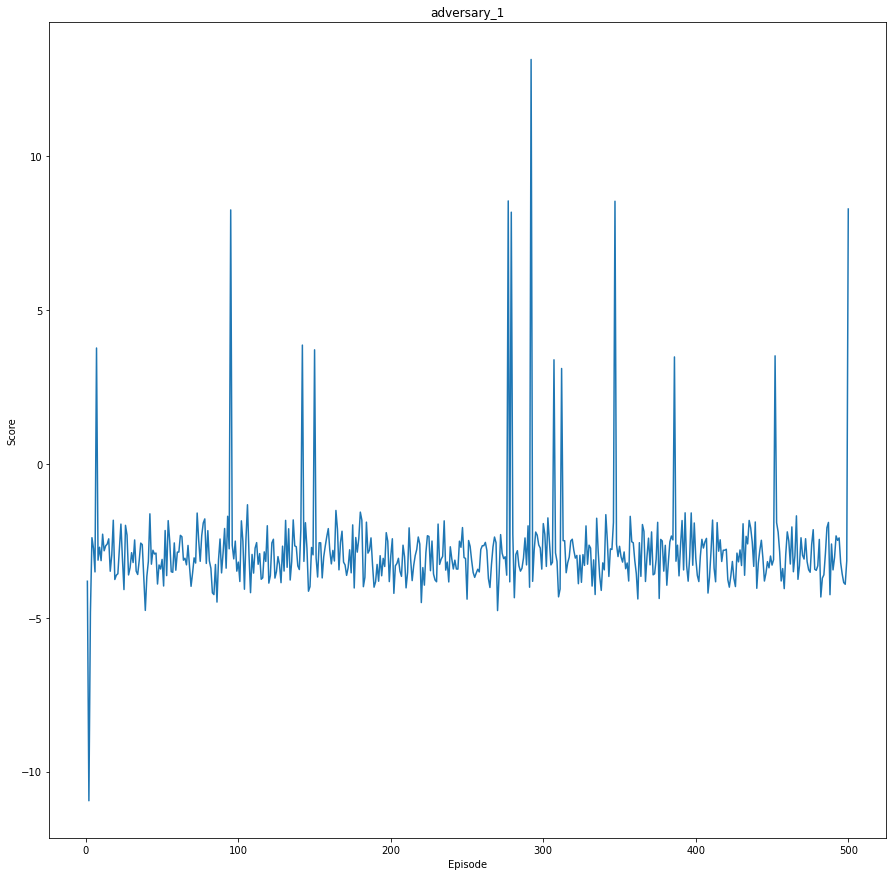

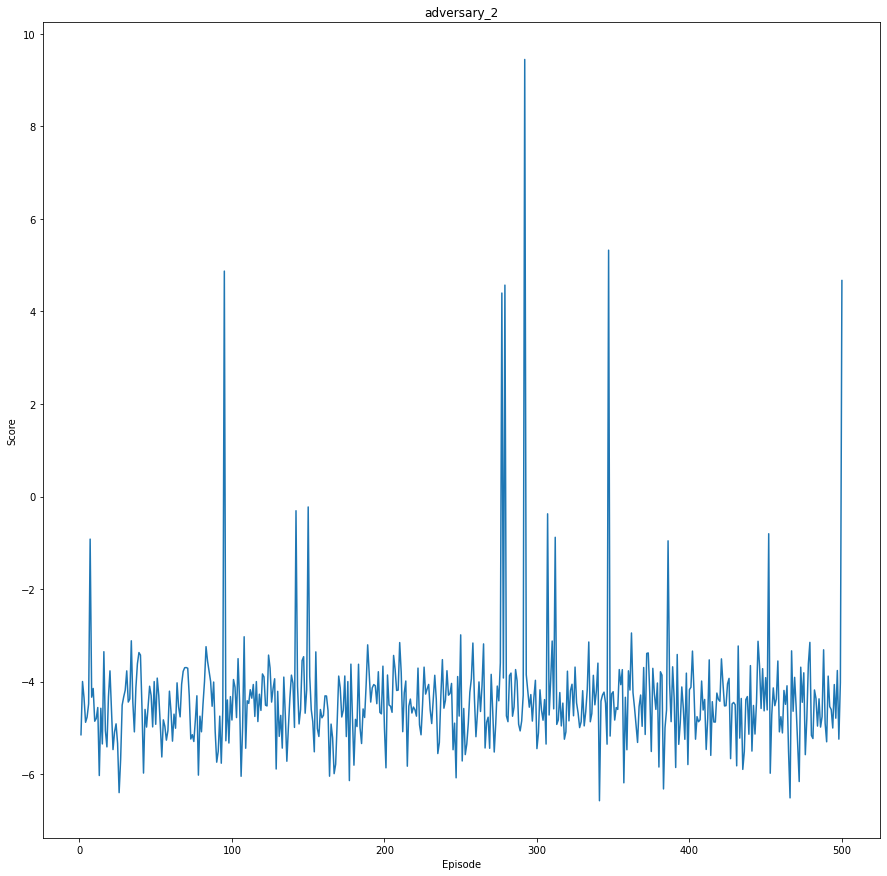

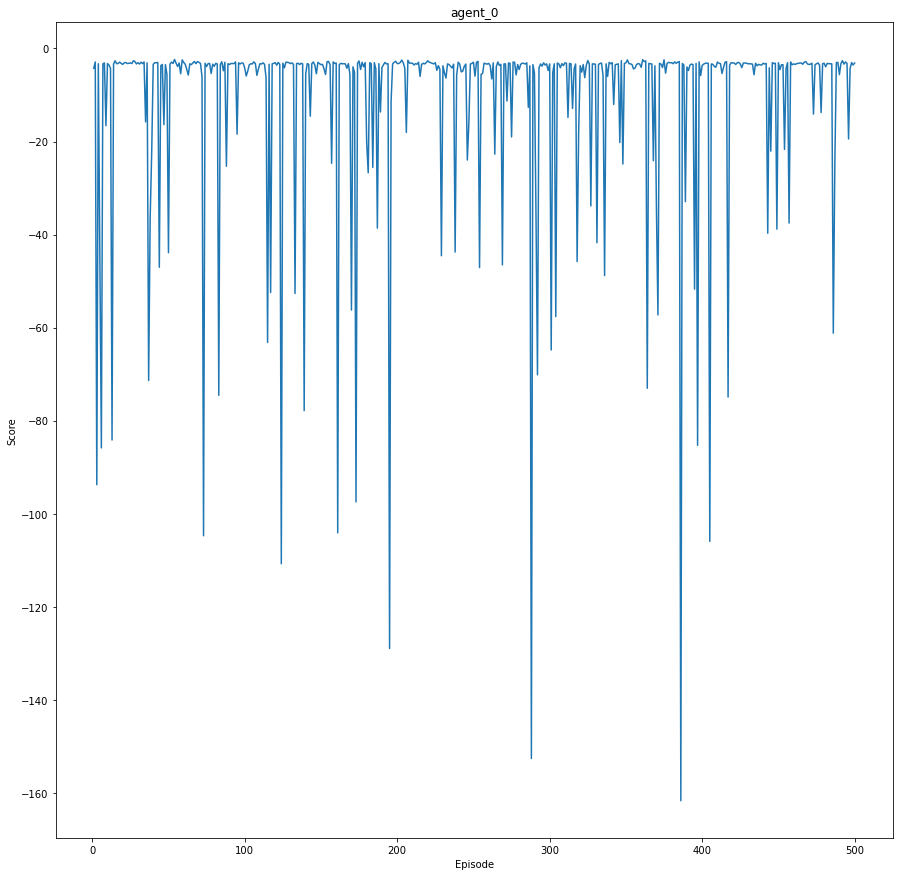

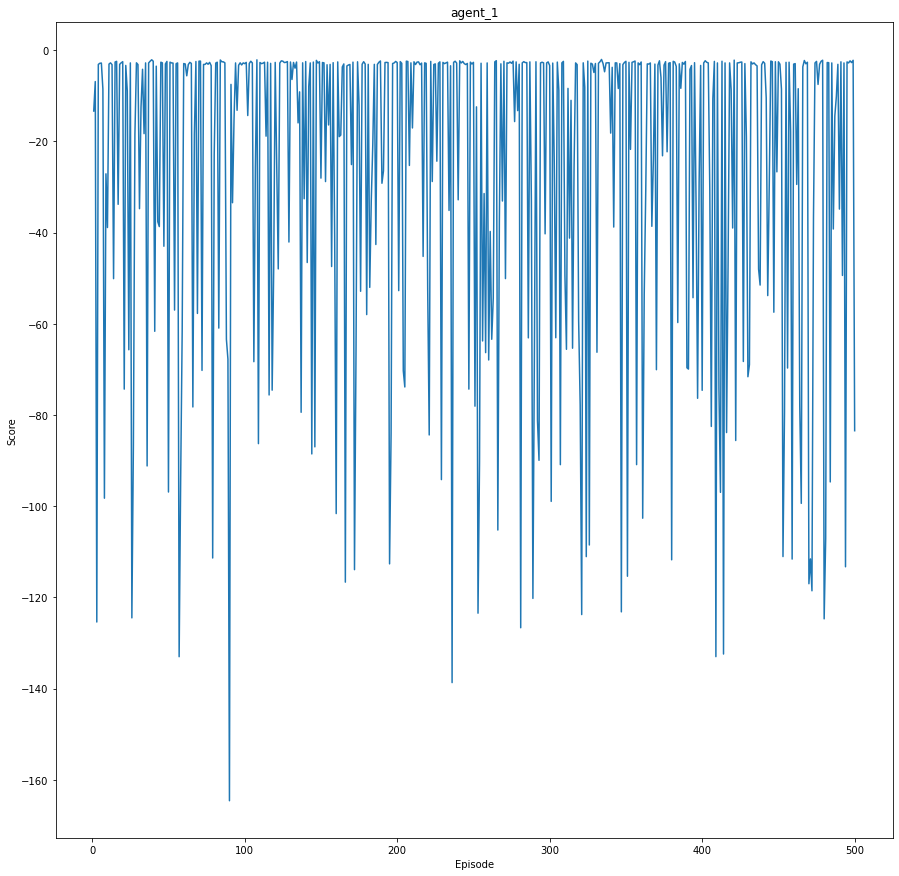

In [13]:
for i in range(0,NUM_OF_AGENTS):
    plt.figure(figsize=(15,15))
    plt.plot(range(1,NUM_OF_EPISODES+1), reward_array[:,i])
    plt.title(inv_agent_map[i])
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.savefig(f"{ENVIRONMENT_NAME}_{inv_agent_map[i]}_learning_"+str(NUM_OF_EPISODES)+"_episodes.png")
    plt.show()

In [14]:
print(agent_models)

{'leadadversary_0': <__main__.agent object at 0x0000020C6C370CD0>, 'adversary_0': <__main__.agent object at 0x0000020C6C3706A0>, 'adversary_1': <__main__.agent object at 0x0000020C6C3706A0>, 'adversary_2': <__main__.agent object at 0x0000020C6C3706A0>, 'agent_0': <__main__.agent object at 0x0000020C05186FA0>, 'agent_1': <__main__.agent object at 0x0000020C05186FA0>}


In [15]:
pprint(vars(env.env.env))

{'_agent_selector': <pettingzoo.utils.agent_selector.agent_selector object at 0x0000020C6C332340>,
 '_cumulative_rewards': {},
 '_index_map': {'adversary_0': 1,
                'adversary_1': 2,
                'adversary_2': 3,
                'agent_0': 4,
                'agent_1': 5,
                'leadadversary_0': 0},
 '_skip_agent_selection': None,
 'action_spaces': {'adversary_0': Discrete(5),
                   'adversary_1': Discrete(5),
                   'adversary_2': Discrete(5),
                   'agent_0': Discrete(5),
                   'agent_1': Discrete(5),
                   'leadadversary_0': Discrete(20)},
 'agent_selection': 'leadadversary_0',
 'agents': [],
 'continuous_actions': False,
 'current_actions': [0, 0, 0, 0, 1, 3],
 'dones': {},
 'infos': {},
 'local_ratio': None,
 'max_cycles': 50,
 'metadata': {'is_parallelizable': True,
              'name': 'simple_world_comm_v2',
              'render_fps': 10,
              'render_modes': ['human', 'rgb_arr

In [16]:
agent_models["adversary_2"].save_model(
    ENVIRONMENT_NAME+"_adversary_2_"+str(NUM_OF_EPISODES)+"_ep_final_model", 
    ENVIRONMENT_NAME+"_adversary_2_"+str(NUM_OF_EPISODES)+"_final_target_model")

In [17]:
agent_models["agent_1"].save_model(
    ENVIRONMENT_NAME+"_agent_1_"+str(NUM_OF_EPISODES)+"_final_model", 
    ENVIRONMENT_NAME+"_agent_1_"+str(NUM_OF_EPISODES)+"_final_target_model")

In [18]:
agent_models["leadadversary_0"].save_model(
    ENVIRONMENT_NAME+"_leadadversary_0_"+str(NUM_OF_EPISODES)+"_ep_final_model", 
    ENVIRONMENT_NAME+"_leadadversary_0_"+str(NUM_OF_EPISODES)+"_final_target_model")